In [294]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [295]:
dados = pd.read_csv("data/ca.csv")

C:\Users\kaio\AppData\Local\Temp\ipykernel_20644\2499396848.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv("data/ca.csv")


In [296]:

# Mostra o nome das colunas
print("Nomes das colunas:")
print(dados.columns)

Nomes das colunas:
Index(['Regiao - Sigla', 'Estado - Sigla', 'Municipio', 'Revenda',
       'CNPJ da Revenda', 'Nome da Rua', 'Numero Rua', 'Complemento', 'Bairro',
       'Cep', 'Produto', 'Data da Coleta', 'Valor de Venda', 'Valor de Compra',
       'Unidade de Medida', 'Bandeira'],
      dtype='object')


In [297]:
# Verificando quais colunas contêm valores nulos
colunas_nulas = dados.isnull().sum()

# Filtrando para mostrar apenas as colunas que têm valores nulos
colunas_com_nulos = colunas_nulas[colunas_nulas > 0]

print("Colunas com valores nulos:")
print(colunas_com_nulos)

Colunas com valores nulos:
Numero Rua            605
Complemento        579320
Bairro               1176
Valor de Compra    740945
dtype: int64


In [298]:
dados['Estado - Sigla'].value_counts()

Estado - Sigla
BA    240700
CE    159862
PE    132842
MA     77758
RN     54326
PB     52367
PI     51767
AL     47837
SE     34418
Name: count, dtype: int64

## Pre-Processamento

In [299]:
print("tamanho dos dados antes do pre-processamento:",len(dados))
dados.head(5)


tamanho dos dados antes do pre-processamento: 851877


,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,CNPJ da Revenda,Nome da Rua,Numero Rua,Complemento,Bairro,Cep,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira
0,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,GASOLINA,02/01/2019,"4,49",NaN,R$ / litro,BRANCA
1,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,ETANOL,02/01/2019,"3,33",NaN,R$ / litro,BRANCA
2,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,DIESEL,02/01/2019,"3,3",NaN,R$ / litro,BRANCA
3,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,DIESEL S10,02/01/2019,"3,4",NaN,R$ / litro,BRANCA
4,NE,AL,ARAPIRACA,POSTO ARAPIRACA LTDA,12.451.076/0001-12,RUA EXPEDICIONARIOS BRASILEIROS,252,NaN,CENTRO,57300-590,GASOLINA,02/01/2019,"4,699","3,8906",R$ / litro,PETROBRAS DISTRIBUIDORA S.A.


In [300]:
dados['Data da Coleta'] = pd.to_datetime(dados['Data da Coleta'], format='%d/%m/%Y')
dados['Valor de Venda'] = dados['Valor de Venda'].str.replace(',', '.', regex=False).astype(float)
dados = dados[dados['Produto'] == 'GASOLINA']
dados = dados[dados['Estado - Sigla'] == 'CE']


dados.set_index('Data da Coleta', inplace=True)

dados['Ano'] = dados.index.year.astype(float)

dados['Mes'] = dados.index.month.astype(float)

dados = dados.drop(columns=['Valor de Compra'])
dados = dados.drop(columns=['Numero Rua'])
dados = dados.drop(columns=['Complemento'])
dados = dados.drop(columns=['CNPJ da Revenda'])


dados.head()


,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,Nome da Rua,Bairro,Cep,Produto,Valor de Venda,Unidade de Medida,Bandeira,Ano,Mes
Data da Coleta,,,,,,,,,,,,,
2019-01-02,NE,CE,CANINDE,POSTO SIM LTDA,ESTRADA BR-020 KM 305,JUBAIA,62700-000,GASOLINA,4.590,R$ / litro,BRANCA,2019.0,1.0
2019-01-02,NE,CE,CANINDE,POSTO SIM LTDA,RUA EUCLIDES BARROSO,SANTA LUZIA,62700-000,GASOLINA,4.499,R$ / litro,BRANCA,2019.0,1.0
2019-01-02,NE,CE,CANINDE,J & J PESSOA COMERCIO DE COMBUSTIVEIS LTDA,AVENIDA PERIMETRAL,CANINDEZINHO,62700-000,GASOLINA,4.599,R$ / litro,BRANCA,2019.0,1.0
2019-01-02,NE,CE,CANINDE,JULIENIA SILVA PESSOA,RUA JOSE VELOSO JUCA,PALESTINA,62700-000,GASOLINA,4.599,R$ / litro,BRANCA,2019.0,1.0
2019-01-02,NE,CE,CANINDE,POSTO ESTRELA COMERCIO DE COMBUSTIVEIS LTDA,AVENIDA LUCIANO MAGALHAES,BELA VISTA,62700-000,GASOLINA,4.649,R$ / litro,RAIZEN,2019.0,1.0


In [301]:
dados['Municipio'].value_counts()

Municipio
FORTALEZA            21713
CAUCAIA               4558
SOBRAL                2616
MARACANAU             2473
JUAZEIRO DO NORTE     2196
CRATO                 2170
IGUATU                1652
LIMOEIRO DO NORTE     1394
QUIXADA               1390
ITAPIPOCA             1232
ICO                   1222
CANINDE               1147
CRATEUS               1131
ARACATI                 39
Name: count, dtype: int64

In [302]:
# Manter apenas as colunas 'Municipio' e 'Valor de Venda'
dados = dados[['Municipio', 'Valor de Venda']]
print(len(dados))

# Filtrar os dados para incluir apenas os municípios de Crato, Juazeiro e Barbalha
municipios_desejados = ['MARACANAU', 'FORTALEZA','CAUCAIA']
dados = dados[dados['Municipio'].isin(municipios_desejados)]

# Reamostrar os dados semanalmente, alinhando as datas ao início do intervalo
dados = dados.groupby('Municipio').resample('W-MON', label='left').mean()

# Preencher os valores NaN com o valor anterior para evitar perda de dados
dados = dados.groupby('Municipio').fillna(method='ffill')

# Resetar o índice e reconfigurar a 'Data da Coleta' como índice
dados = dados.reset_index()
dados.set_index('Data da Coleta', inplace=True)

# Ordenar os dados pelo índice
dados = dados.sort_index()

# Adicionar as colunas 'Ano' e 'Mes'
dados['Ano'] = dados.index.year.astype(float)
dados['Mes'] = dados.index.month.astype(float)


44933


C:\Users\kaio\AppData\Local\Temp\ipykernel_20644\3256400274.py:13: FutureWarning: DataFrameGroupBy.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados = dados.groupby('Municipio').fillna(method='ffill')
C:\Users\kaio\AppData\Local\Temp\ipykernel_20644\3256400274.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados = dados.groupby('Municipio').fillna(method='ffill')


In [303]:
dados['Municipio'].value_counts()

Municipio
CAUCAIA      261
FORTALEZA    261
MARACANAU    261
Name: count, dtype: int64

In [304]:
print("tamanho dos dados após pre-processamento:",len(dados))
dados.head(5)

tamanho dos dados após pre-processamento: 783


,Municipio,Valor de Venda,Ano,Mes
Data da Coleta,,,,
2018-12-31,CAUCAIA,4.342619,2018.0,12.0
2018-12-31,FORTALEZA,4.293604,2018.0,12.0
2018-12-31,MARACANAU,4.252600,2018.0,12.0
2019-01-07,CAUCAIA,4.255571,2019.0,1.0
2019-01-07,FORTALEZA,4.216802,2019.0,1.0


In [305]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import pandas as pd

# Definindo colunas categóricas e numéricas
categorical_features = ['Municipio']
numeric_features = ['Ano', 'Mes','Valor de Venda']

# Separando as features e o target
X = dados[categorical_features + numeric_features]
y = dados['Valor de Venda']

# Determinando os tamanhos dos conjuntos de treino, validação e teste
n = len(X)
train_size = int(n * 0.72)  # 72% para treino
val_size = int(n * 0.18)    # 18% para validação
test_size = n - train_size - val_size  # 10% para teste

# Dividindo os dados
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

# Configurando o pré-processador para aplicar OneHotEncoding apenas nas colunas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Mantém as features numéricas na escala original
)

# Criando o pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplicando o pipeline aos dados de treino e transformando
X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)
X_test_transformed = pipeline.transform(X_test)

# Obtendo os nomes das colunas após o OneHotEncoding e mantendo as colunas numéricas
categorical_feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
all_feature_names = list(categorical_feature_names) + numeric_features

# Convertendo as matrizes para DataFrames e ajustando os índices para frequência diária
X_train_transformed_df = pd.DataFrame(X_train_transformed, 
                                      columns=all_feature_names,
                                      index=X_train.index)

X_val_transformed_df = pd.DataFrame(X_val_transformed, 
                                    columns=all_feature_names,
                                    index=X_val.index)

X_test_transformed_df = pd.DataFrame(X_test_transformed, 
                                     columns=all_feature_names,
                                     index=X_test)

# Verificando os tamanhos dos conjuntos e o ajuste de índices
print("Treinamento:", X_train_transformed_df.shape)
print("Validação:", X_val_transformed_df.shape)
print("Teste:", X_test_transformed_df.shape)

'''# Adicionando a coluna 'Valor de Venda' aos dados de treino e validação originais
dados_treino = X_train.copy()
dados_val = X_val.copy()

dados_treino['Valor de Venda'] = y_train
dados_val['Valor de Venda'] = y_val'''


Treinamento: (563, 6)
Validação: (140, 6)
Teste: (80, 6)


"# Adicionando a coluna 'Valor de Venda' aos dados de treino e validação originais\ndados_treino = X_train.copy()\ndados_val = X_val.copy()\n\ndados_treino['Valor de Venda'] = y_train\ndados_val['Valor de Venda'] = y_val"

In [306]:
# Concatenando os DataFrames transformados de treinamento e validação
X_train_val = pd.concat([X_train, X_val])

# Concatenando os valores de y correspondentes para treinamento e validação
y_train_val_combined = pd.concat([y_train, y_val])

# Adicionando a coluna 'Valor de Venda' ao DataFrame combinado
X_train_val['Valor de Venda'] = y_train_val_combined.values

# Verificando o resultado
display(X_train_val.head())
print("Tamanho do DataFrame combinado:", X_train_val.shape)


,Municipio,Ano,Mes,Valor de Venda
Data da Coleta,,,,
2018-12-31,CAUCAIA,2018.0,12.0,4.342619
2018-12-31,FORTALEZA,2018.0,12.0,4.293604
2018-12-31,MARACANAU,2018.0,12.0,4.252600
2019-01-07,CAUCAIA,2019.0,1.0,4.255571
2019-01-07,FORTALEZA,2019.0,1.0,4.216802


Tamanho do DataFrame combinado: (703, 4)


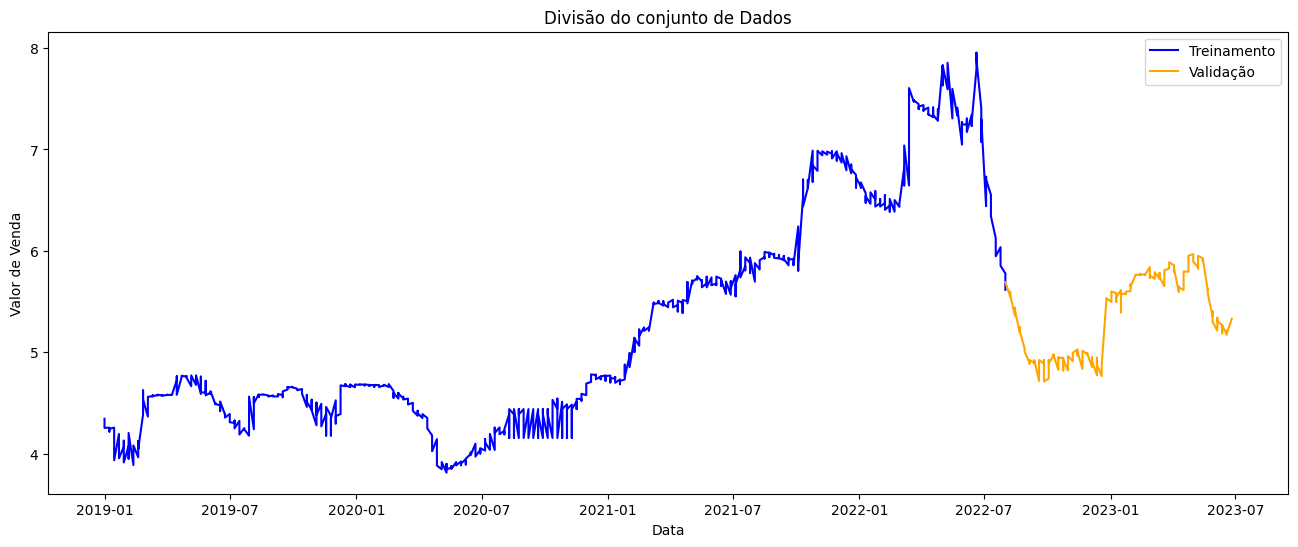

In [307]:
plt.figure(figsize=(16,6))

plt.title("Divisão do conjunto de Dados")

plt.plot(y_train,label='Treinamento', color='blue')
plt.plot(y_val,label='Validação', color='orange')

plt.xlabel("Data")
plt.ylabel("Valor de Venda")
plt.legend()

plt.show()

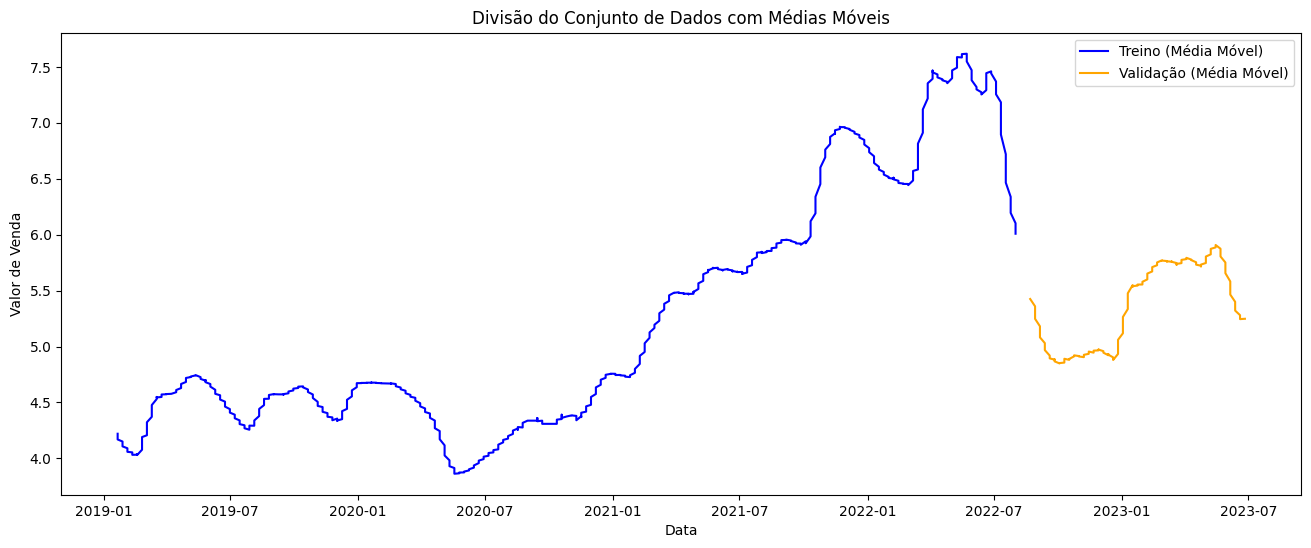

In [308]:
# Aplicando médias móveis com uma janela de 10 períodos (por exemplo)
y_train_rolling = y_train.rolling(window=10).mean()
y_val_rolling = y_val.rolling(window=10).mean()

# Plotando as médias móveis
plt.figure(figsize=(16, 6))

plt.title("Divisão do Conjunto de Dados com Médias Móveis")

plt.plot(y_train_rolling, label='Treino (Média Móvel)', color='blue')
plt.plot(y_val_rolling, label='Validação (Média Móvel)', color='orange')

plt.xlabel("Data")
plt.ylabel("Valor de Venda")
plt.legend()

plt.show()


# log linear e usar linear 
# depois pegar o residuo do modelo linear e usar na arvore de decisao

## Análise de Autocorrelação

<function matplotlib.pyplot.show(close=None, block=None)>

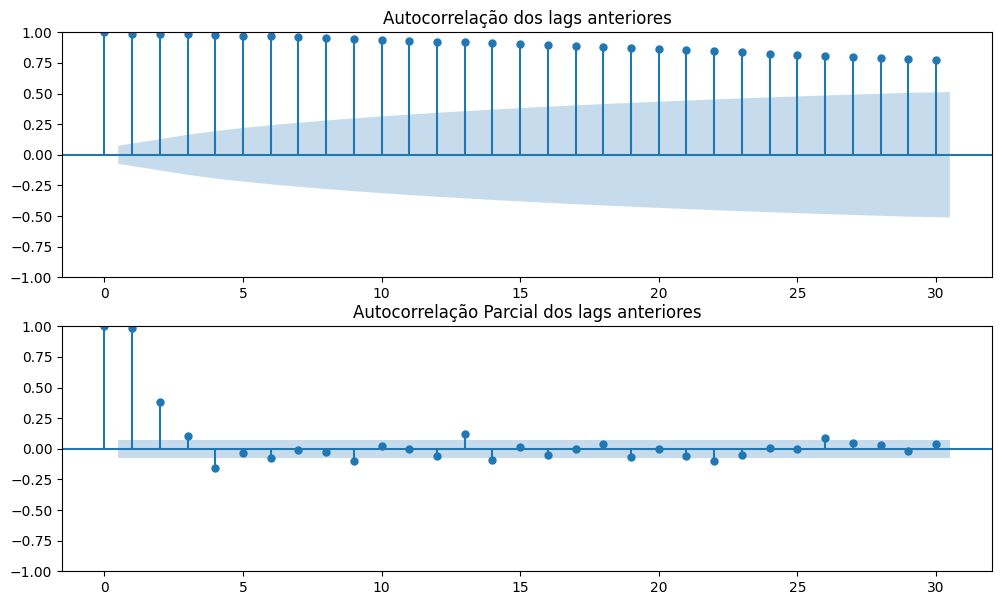

In [309]:
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(211)
fig = plot_acf(X_train_val['Valor de Venda'], lags=30, ax=ax1)
ax1.set_title("Autocorrelação dos lags anteriores")

ax2 = fig.add_subplot(212)
fig = plot_pacf(X_train_val['Valor de Venda'], lags=30, ax=ax2)
ax2.set_title("Autocorrelação Parcial dos lags anteriores")

plt.show

# Devo continuar usando os Dados completos aqui?

Lags Significantes: [1, 2, 3, 4, 5, 6, 9, 13, 18, 21, 22, 23, 26, 27, 28]


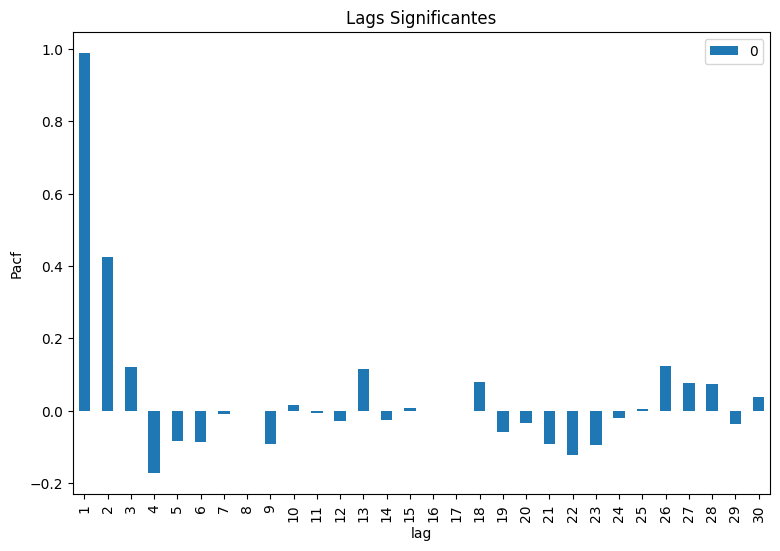

In [310]:
from statsmodels.tsa.stattools import pacf

def getSignificantLags(y, nLags = 5, alpha=0.05):
    Pacf, Pacf_intervalos =  pacf(x=y, nlags=nLags, alpha=alpha)
    pd.DataFrame(Pacf)[1:].plot(kind='bar', figsize=(9,6), legend='pacf valores',
                               xlabel='lag', ylabel='Pacf');
    significantLags = []
    for i in range(1, len(Pacf)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if Pacf[i] < Pacf_intervalos[i][0] - Pacf[i] or Pacf[i] > Pacf_intervalos[i][1] - Pacf[i]:
            significantLags.append(i)
    print('Lags Significantes:', significantLags)
    return significantLags

DT_significantLags = getSignificantLags(dados['Valor de Venda'], nLags = 30, alpha=0.05)
plt.title("Lags Significantes")
plt.show()
# Colocar 100 de valores de lag

## Modelagem

In [311]:
def appendLagVariables(y, significantLags, df, dropna=True, previousData=None):
    prefix = y.replace(')', '')
    df = df.copy()  # Fazendo uma cópia para evitar modificar o original
    lowerIndex = 0
    x = df[y]
    
    if previousData is not None:
        x = pd.concat([previousData[y], x])
        lowerIndex = previousData.shape[0]
    
    for lag in significantLags:
        varNm = prefix + '-' + str(lag) + ')'
        df[varNm] = x.shift(lag)[lowerIndex:]
    
    if dropna:
        # Dropar apenas linhas onde os NaN estão nas colunas de lag, preservando a coluna 'Valor de Venda'
        lag_columns = [prefix + '-' + str(lag) + ')' for lag in significantLags]
        df.dropna(subset=lag_columns, inplace=True)
        
    return df

# Usar a função para gerar as variáveis de lag e atribuir ao DataFrame X_train_transformed_df
X_train_transformed_df = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_train_transformed_df, 
    dropna=True
)

X_val_transformed_df = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_val_transformed_df, 
    dropna=True
)

X_test_transformed_df = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_test_transformed_df, 
    dropna=True
)

X_val = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_val, 
    dropna=True
)

y_train = X_train_transformed_df['Valor de Venda']
y_val = X_val_transformed_df['Valor de Venda']
y_test = X_test_transformed_df['Valor de Venda']



X_val_transformed_df = X_val_transformed_df.drop(columns=['Valor de Venda'])
X_test_transformed_df = X_test_transformed_df.drop(columns=['Valor de Venda'])
X_train_transformed_df = X_train_transformed_df.drop(columns=['Valor de Venda'])


In [312]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Inicializando o modelo
reg = DecisionTreeRegressor()

# Treinando o modelo
reg.fit(X_train_transformed_df, y_train.values.ravel())  # Convertendo y_train para um array 1D

# Fazendo previsões
predicao = reg.predict(X_val_transformed_df)

# Garantindo que y_val seja uma Series e não um DataFrame
y_val_series = y_val.values.ravel()  # Convertendo y_val para um array 1D

# Calculando a diferença entre os valores reais e previstos
diferenca = mean_squared_error(y_val_series, predicao)

# Se você precisar imprimir ou fazer algo com a diferença
print(f"MSE (Mean Squared Error): {diferenca}")




MSE (Mean Squared Error): 0.05819948700872403


In [313]:
# Fazendo previsões
predicao = reg.predict(X_val_transformed_df)


# Criando um DataFrame com valores reais e previstos, mantendo os índices
df_comparacao = pd.DataFrame({
    'Valor Real': y_val_series,
    'Valor Previsto_DT': predicao
}, index=y_val.index)

# Supondo que 'Municipio' esteja em X_val
# Adicionando a coluna 'Municipio' ao DataFrame df_comparacao
df_comparacao['Municipio'] = X_val['Municipio']

# Mostrando o DataFrame
display(df_comparacao)



,Valor Real,Valor Previsto_DT,Municipio
Data da Coleta,,,
2022-10-10,4.967500,5.481381,MARACANAU
2022-10-10,4.976429,5.001381,CAUCAIA
2022-10-10,4.970851,5.001381,FORTALEZA
2022-10-17,4.825000,5.001381,MARACANAU
2022-10-17,4.950375,5.001381,FORTALEZA
...,...,...,...
2023-06-12,5.265000,5.481381,CAUCAIA
2023-06-19,5.172500,5.481381,MARACANAU
2023-06-19,5.212857,5.481381,CAUCAIA


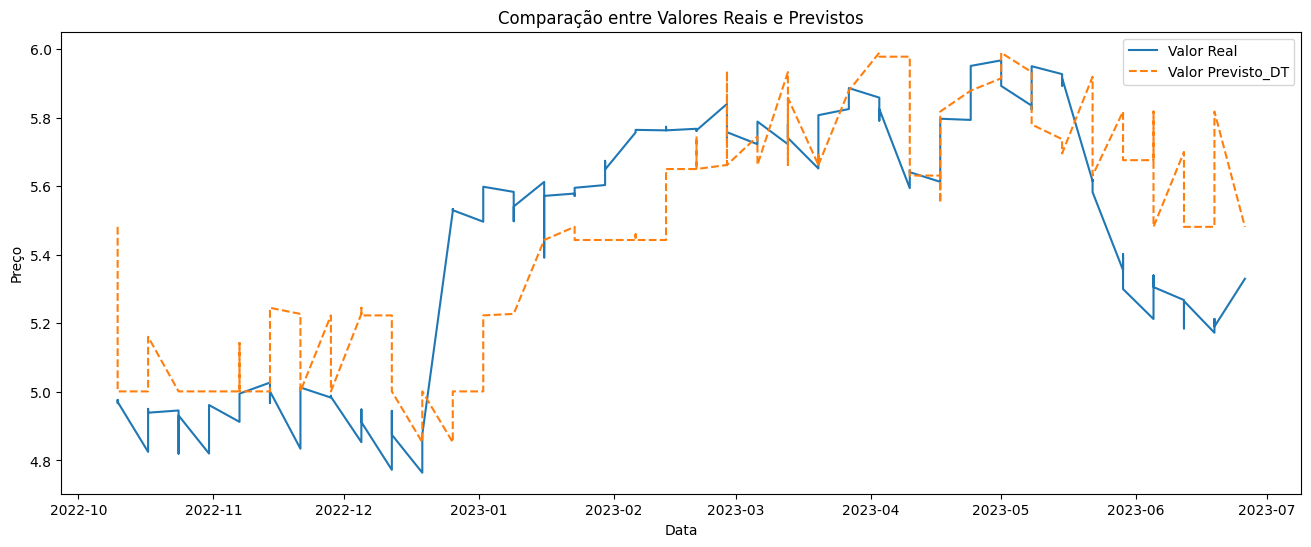

In [314]:
# Plotando os resultados
plt.figure(figsize=(16, 6))
plt.plot(df_comparacao['Valor Real'], label='Valor Real')
plt.plot(df_comparacao['Valor Previsto_DT'], label='Valor Previsto_DT', linestyle='--')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


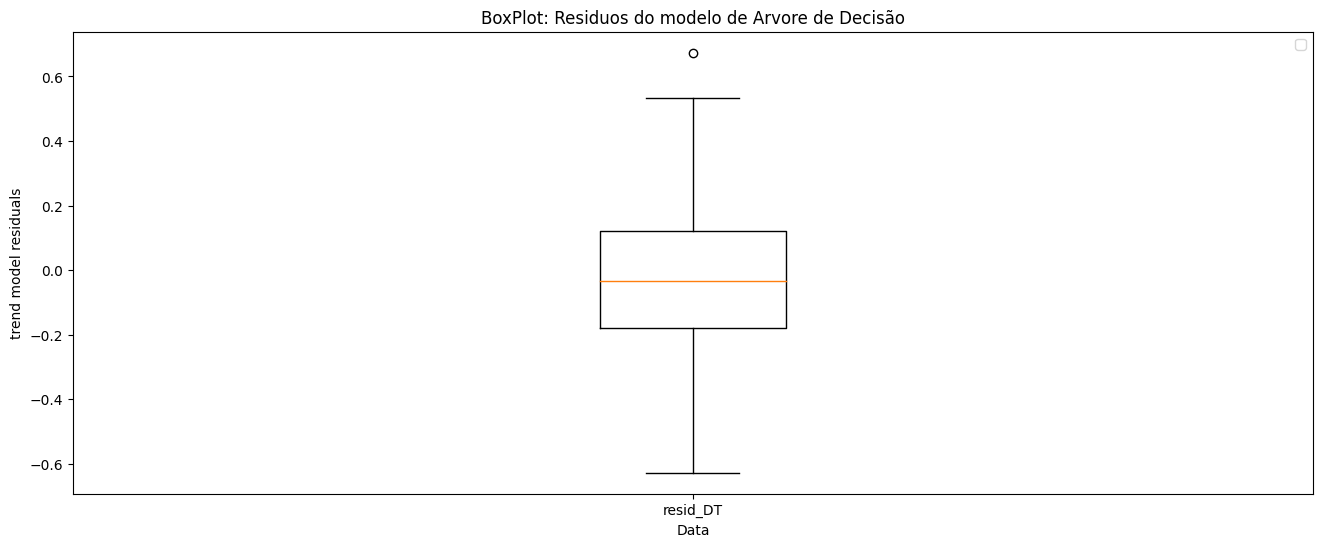

In [315]:
df_comparacao['resid_DT'] = df_comparacao['Valor Real'].subtract(df_comparacao['Valor Previsto_DT'])
plt.figure(figsize=(16, 6))
plt.boxplot(df_comparacao[['resid_DT']].iloc[1:, :], 
            labels = ['resid_DT'])

plt.title("BoxPlot: Residuos do modelo de Arvore de Decisão")
plt.xlabel('Data')
plt.ylabel('trend model residuals')
plt.legend()

plt.show()

# Residuos e outliers possuem simetria
# errando entre menos meio e meio

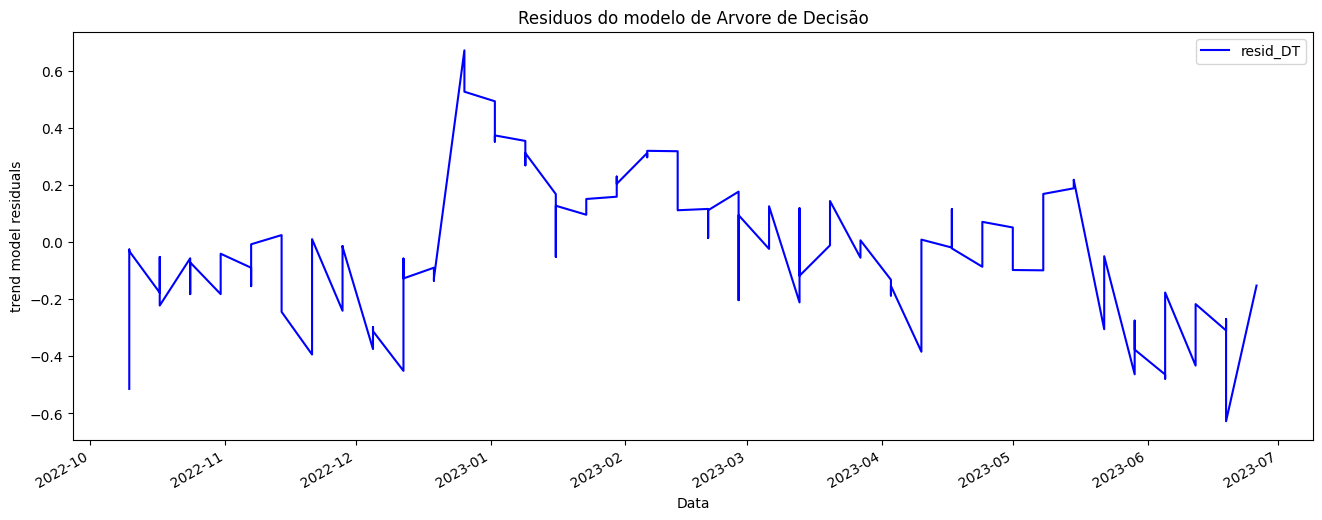

In [316]:
df_comparacao[['resid_DT']].plot(color=['b'], figsize=(16,6), ylabel='trend model residuals')

plt.title("Residuos do modelo de Arvore de Decisão")
plt.xlabel('Data')
plt.ylabel('trend model residuals')
plt.legend()

plt.show()
# Fazer auto correlação nos residuos e verificar se este é modelavel

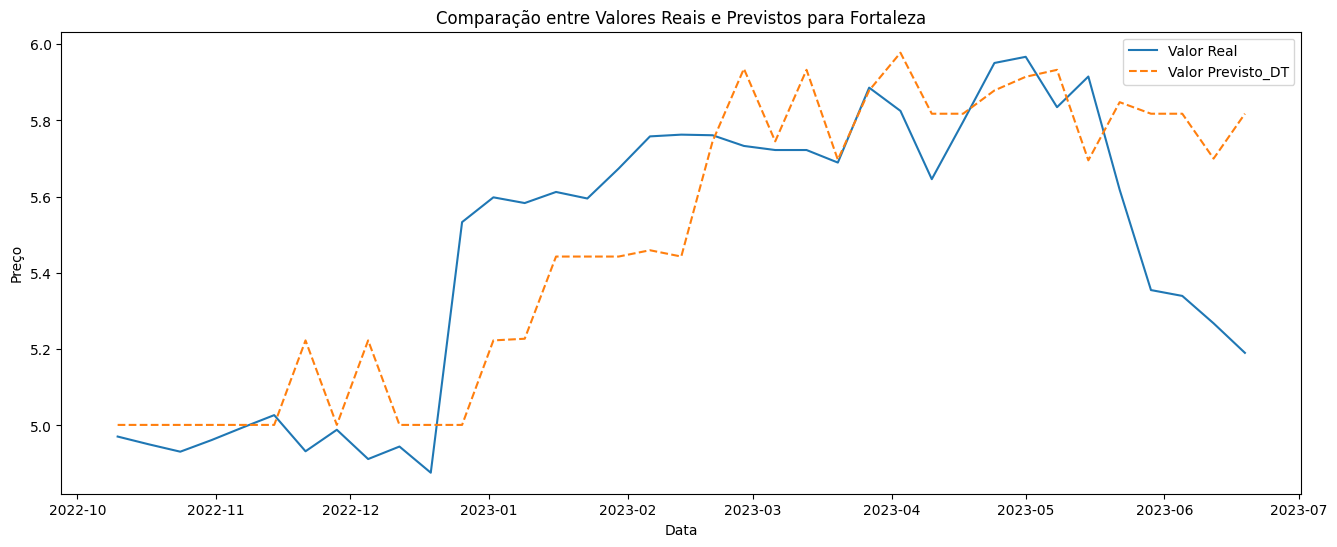

In [317]:
import matplotlib.pyplot as plt

# Filtrar o DataFrame para incluir apenas os dados de Fortaleza
df_fortaleza = df_comparacao[df_comparacao['Municipio'] == 'FORTALEZA']

# Criar o gráfico
plt.figure(figsize=(16, 6))
plt.plot(df_fortaleza['Valor Real'], label='Valor Real')
plt.plot(df_fortaleza['Valor Previsto_DT'], label='Valor Previsto_DT', linestyle='--')
plt.title('Comparação entre Valores Reais e Previstos para Fortaleza')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

# Tentar trabalhar com valor medio de preço para postos ou para municipios
# Tentar pegar media das semanas 


<Axes: xlabel='Valor Previsto_DT', ylabel='Valor Real'>

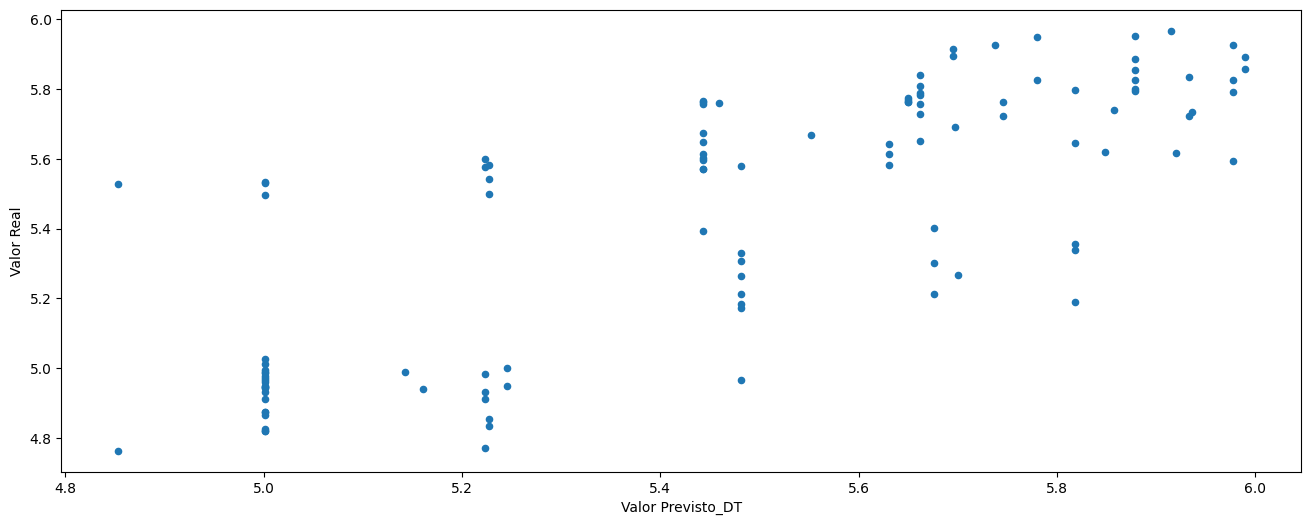

In [318]:
df_comparacao.plot(x = 'Valor Previsto_DT', y='Valor Real', figsize=(16,6), kind='scatter')

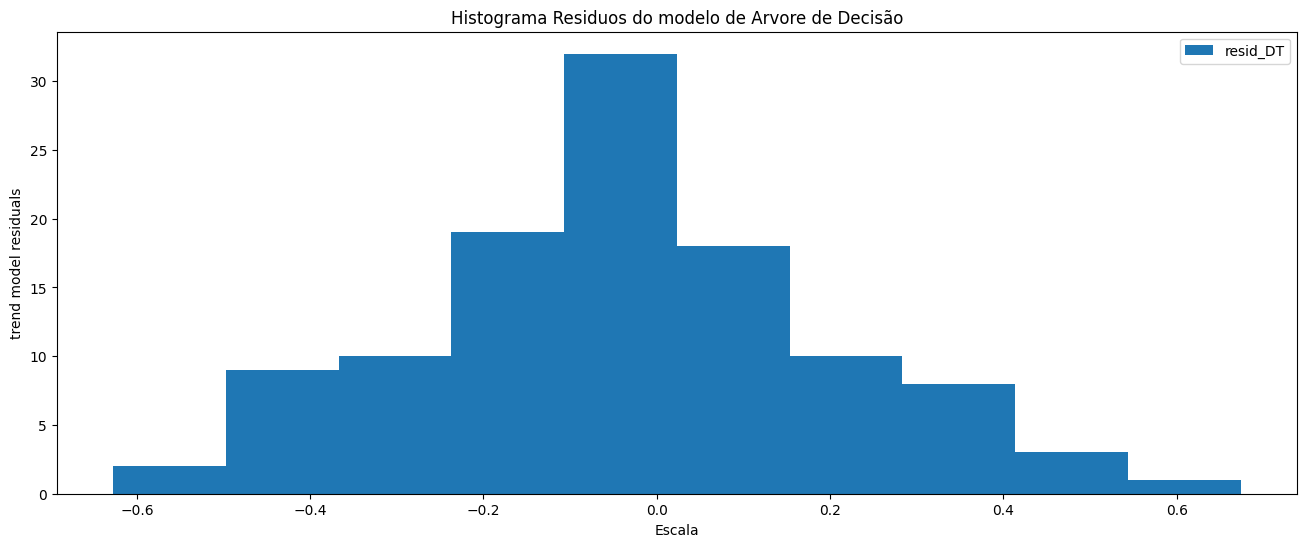

In [319]:
df_comparacao['resid_DT'].plot(kind='hist', figsize=(16,6), ylabel = 'resid_DT')

plt.title("Histograma Residuos do modelo de Arvore de Decisão")
plt.xlabel('Escala')
plt.ylabel('trend model residuals')
plt.legend()

plt.show()

# Fazer teste de shapiro 
# colocar ao lado do box plot e usar melhor quando for analisado a correlação dos residuos